In [53]:
#Step 1: Import the basic libraries and parse the data and save it as a df


import xml.etree.ElementTree as ET
from collections import defaultdict
import pandas as pd

# Replace this path with your export.xml location
xml_file = "/Users/vaswatihazarika/Downloads/apple_health_export/export.xml"

print("Parsing Apple Health export...")

tree = ET.parse(xml_file)
root = tree.getroot()

# Dictionary to sum steps per day
steps_per_day = defaultdict(int)

for record in root.findall('Record'):
    if record.attrib.get('type') == 'HKQuantityTypeIdentifierStepCount':
        # Start and end dates look like '2025-07-20 12:00:00 +0000'
        start_date = record.attrib.get('startDate').split(' ')[0]
        step_count = int(float(record.attrib.get('value')))
        steps_per_day[start_date] += step_count

# Convert to DataFrame
df_steps = pd.DataFrame([
    {'date': date, 'steps': steps} 
    for date, steps in steps_per_day.items()
])

# Sort by date
df_steps['date'] = pd.to_datetime(df_steps['date'])
df_steps = df_steps.sort_values('date')

# Save to CSV
df_steps.to_csv('/Users/vaswatihazarika/Downloads/apple_watch_steps.csv', index=False)
print("Saved daily steps to apple_watch_steps.csv")


Parsing Apple Health export...
Saved daily steps to apple_watch_steps.csv


#Step 1.a : Check the structure of your data

In [15]:
df_steps.head()

,date,steps
1002,2021-05-07,339
1003,2021-05-08,1138
1004,2021-05-09,1699
1005,2021-05-10,1080
1006,2021-05-11,1316


In [16]:
#Step 1.b Data Wrangling : convert the date to date time

df_steps['date'] = pd.to_datetime(df_steps['date'])
df_steps = df_steps.sort_values('date')
df_steps.head()

,date,steps
1002,2021-05-07,339
1003,2021-05-08,1138
1004,2021-05-09,1699
1005,2021-05-10,1080
1006,2021-05-11,1316


In [4]:
#Step 1.c : Future deployments : Filter by steps > 10,000
filtered_df = df_steps[df_steps['steps'] > 10000]
filtered_df.head()


,date,steps
955,2021-10-14,14900
957,2021-10-16,17220
979,2021-11-07,12254
984,2021-11-12,17717
985,2021-11-13,13586


In [5]:
#Step 1.d : Future deployments : Filter by Date
df_steps[df_steps['date'] >= '2025-07-01']


,date,steps
1343,2025-07-01,10878
1344,2025-07-02,26527
1345,2025-07-03,11699
1346,2025-07-04,27427
1347,2025-07-05,17618
1348,2025-07-06,21712
1349,2025-07-07,41661
1350,2025-07-08,12790
1351,2025-07-09,23001
1352,2025-07-10,17654


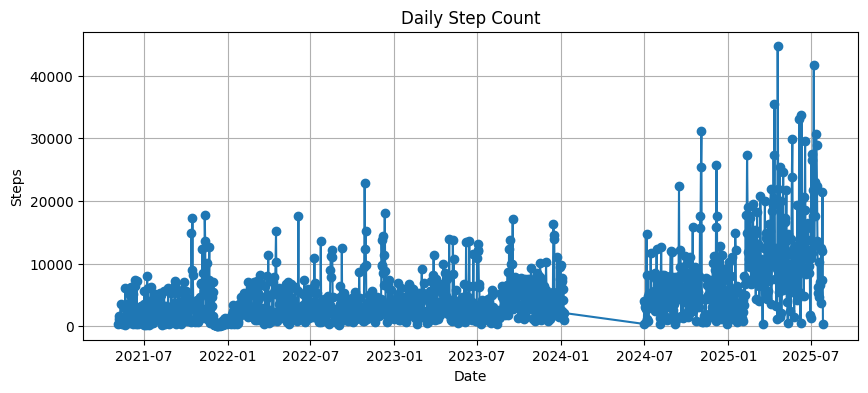

In [17]:
#Step 2.a : Basic EDA to see the data pre-processing

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df_steps['date'], df_steps['steps'], marker='o')
plt.title("Daily Step Count")
plt.xlabel("Date")
plt.ylabel("Steps")
plt.grid(True)
plt.show()


In [18]:
# Step 2.b Check for missing dates and fill

df_steps['date'] = pd.to_datetime(df_steps['date'])
df_steps = df_steps.set_index('date').sort_index()
all_days = pd.date_range(df_steps.index.min(), df_steps.index.max())
df_steps = df_steps.reindex(all_days, fill_value=0)
df_steps.rename_axis('date', inplace=True)

print(df_steps.head())


            steps
date             
2021-05-07    339
2021-05-08   1138
2021-05-09   1699
2021-05-10   1080
2021-05-11   1316


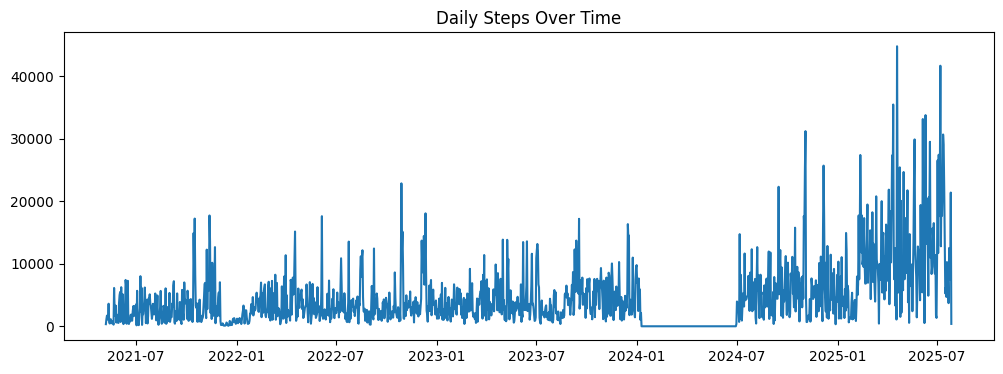

In [19]:
#Step 2: EDA
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df_steps.index, df_steps['steps'])
plt.title("Daily Steps Over Time")
plt.show()


In [21]:
#Check stationarity with Augmented Dicky Fuller
#Step 3.a Pre Fitting : Tests : Augmented Dicky Fuller 
!pip install statsmodels
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_steps['steps'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 8.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [statsmodels] [statsmodels]
ADF Statistic: -2.582028237023551
p-value: 0.09676884445676076


#Results for step 3. a: ADF (augmented dicky fuller) test shows that while the ADF statistic is negative (only slightly) [Note: more negative the ADF, the better], the p value > 0.05, rejecting the null hypothesis that the time series is stationary. We will accept the alternative hypothesis that the time series is non-stationary.

In [2]:
#Step 3.b Model evaluation : we will use ARIMA model at first to see if it can best fit the data


In [23]:
#Lets do first order differntial- step down to identify the next step

df_steps['steps_diff'] = df_steps['steps'].diff()
df_steps = df_steps.dropna()



In [24]:
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(df_steps['steps_diff'])
print(f'ADF Statistic (1st diff): {result_diff[0]}')
print(f'p-value (1st diff): {result_diff[1]}')


ADF Statistic (1st diff): -14.105767939820549
p-value (1st diff): 2.5712154301927843e-26


#Results the p value is lower than 0.05 so this statistic is great. we accept the null hypothesis that ARI(1)MA has created a stationary time series - the first differential

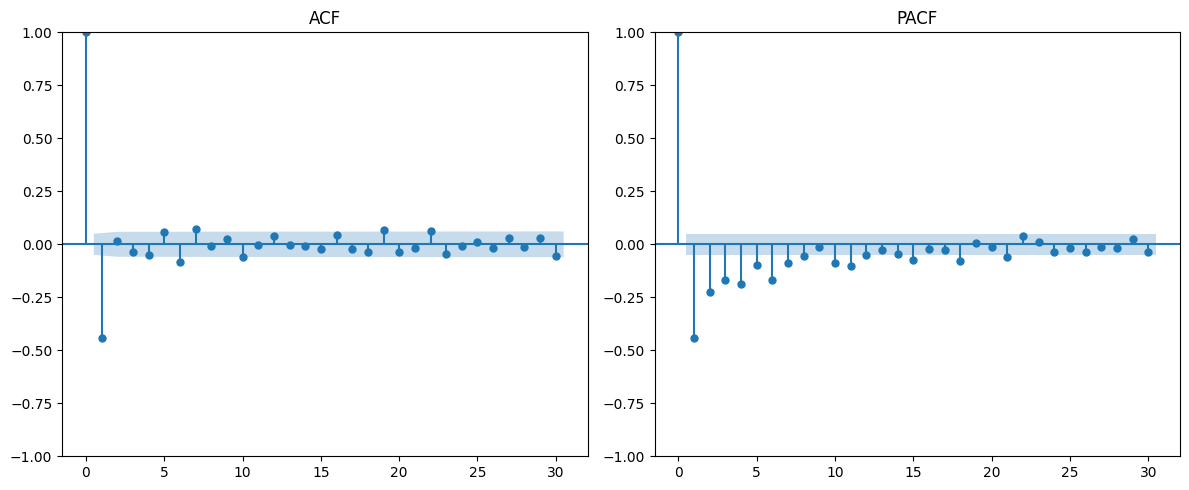

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_acf(df_steps['steps_diff'], lags=30, ax=plt.gca())
plt.title('ACF')

plt.subplot(1, 2, 2)
plot_pacf(df_steps['steps_diff'], lags=30, ax=plt.gca())
plt.title('PACF')

plt.tight_layout()
plt.show()


In [ ]:
#Fit the correct model 
#p=1 , q=0, d=1 this looks like the best seeing the ACF and PACF graphs visually - as and when the number becomes constant that the order for AR/MA


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_steps['steps'], order=(2,1,1))
model_fit = model.fit()

In [36]:
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  steps   No. Observations:                 1542
Model:                 ARIMA(2, 1, 1)   Log Likelihood              -14933.890
Date:                Sun, 27 Jul 2025   AIC                          29875.780
Time:                        17:26:20   BIC                          29897.141
Sample:                    05-08-2021   HQIC                         29883.727
                         - 07-27-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2282      0.018     12.582      0.000       0.193       0.264
ar.L2          0.1254      0.019      6.544      0.000       0.088       0.163
ma.L1         -0.9571      0.007   -132.746      0.0

Results : the ARIMA (2,1,1) SHOWS THE BEST results however we can tell that Heteroskadesticity and non normality are problems in the data set indicating we need to treat it. 
we used log likelihood as it was a better fit. Now we will use Box Cox to reduce heteroskadesticity. 


In [37]:
#Box-Cox 

from scipy.stats import boxcox

# Add a small constant if there are any 0s
df_steps['steps_adj'] = df_steps['steps'] + 1

# Box-Cox transform
df_steps['steps_boxcox'], fitted_lambda = boxcox(df_steps['steps_adj'])

print(f"Best lambda for Box-Cox: {fitted_lambda}")


Best lambda for Box-Cox: 0.3306426016358998


In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_steps['steps_boxcox'], order=(2, 1, 2))  # or use auto_arima
results = model.fit(disp=False)
print(results.summary())


                               SARIMAX Results                                
Dep. Variable:           steps_boxcox   No. Observations:                 1542
Model:               SARIMAX(2, 1, 2)   Log Likelihood               -5934.605
Date:                Sun, 27 Jul 2025   AIC                          11879.211
Time:                        17:33:51   BIC                          11905.912
Sample:                    05-08-2021   HQIC                         11889.145
                         - 07-27-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1511      0.250      0.603      0.546      -0.340       0.642
ar.L2          0.1204      0.051      2.363      0.018       0.021       0.220
ma.L1         -0.8296      0.254     -3.261      0.0

Results: Here the heteroscedasticity is gone, however it looks like the residuals need further treatment to remove autocorrelation. Therefore we will use GARCH


In [46]:
!pip install garch
!pip install arch

from arch import arch_model

# Get residuals from ARIMA model
residuals = results.resid

# Fit GARCH(1,1)
garch_model = arch_model(residuals, vol='GARCH', p=1, q=2)
garch_results = garch_model.fit()
print(garch_results.summary())


Iteration:      1,   Func. Count:      7,   Neg. LLF: 3145365.554757175
Iteration:      2,   Func. Count:     14,   Neg. LLF: 6017.155368252357
Iteration:      3,   Func. Count:     21,   Neg. LLF: 22507.88339193424
Iteration:      4,   Func. Count:     28,   Neg. LLF: 5945.999735139363
Iteration:      5,   Func. Count:     35,   Neg. LLF: 122311.15883354846
Iteration:      6,   Func. Count:     42,   Neg. LLF: 2105662.4061306925
Iteration:      7,   Func. Count:     49,   Neg. LLF: 5947.41829553503
Iteration:      8,   Func. Count:     56,   Neg. LLF: 2200396.756936309
Iteration:      9,   Func. Count:     64,   Neg. LLF: 7502.739164946607
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12812.602615783258
Iteration:     11,   Func. Count:     78,   Neg. LLF: 5835.766927284395
Iteration:     12,   Func. Count:     85,   Neg. LLF: 6777.531989013645
Iteration:     13,   Func. Count:     92,   Neg. LLF: 58160.112883982074
Iteration:     14,   Func. Count:     99,   Neg. LLF: 5730.11

In [ ]:
Now autocorrelation is taken care of. We will now look at GARCH(1,2) as it was the best 

In [ ]:
df_steps

,steps,steps_diff,steps_adj,steps_boxcox
date,,,,
2021-05-08,1138,799.0,1139,27.968196
2021-05-09,1699,561.0,1700,32.356189
2021-05-10,1080,-619.0,1081,27.437221
2021-05-11,1316,236.0,1317,29.492487
2021-05-12,3606,2290.0,3607,42.347307
...,...,...,...,...
2025-07-23,12516,8815.0,12517,65.437547
2025-07-24,11996,-520.0,11997,64.483764
2025-07-25,7456,-4540.0,7457,54.662310


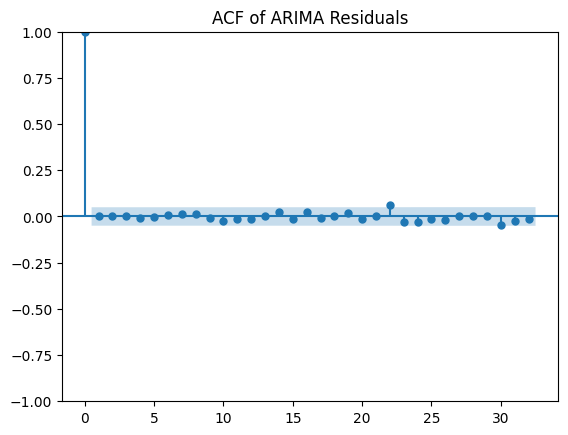

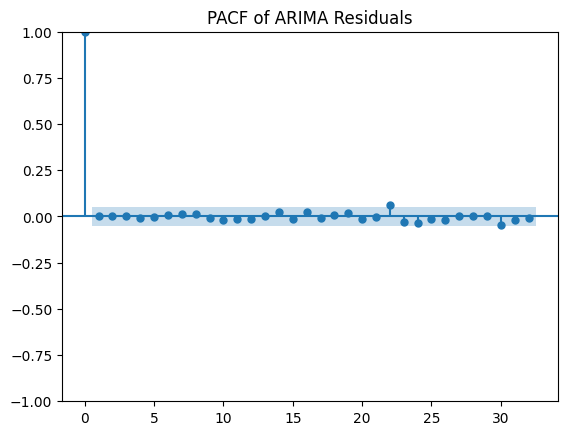

Ljung-Box Test:
     lb_stat  lb_pvalue
10  1.683504   0.998241


In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

residuals = results.resid

plot_acf(residuals)
plt.title("ACF of ARIMA Residuals")
plt.show()

plot_pacf(residuals)
plt.title("PACF of ARIMA Residuals")
plt.show()

# Ljung-Box Test
from statsmodels.stats.diagnostic import acorr_ljungbox
ljung = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test:")
print(ljung)


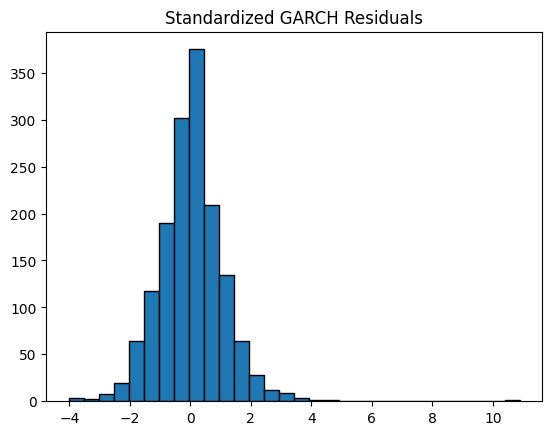

α + β = 0.605 (should be < 1)


In [47]:
# Histogram of standardized residuals
plt.hist(garch_results.std_resid, bins=30, edgecolor='black')
plt.title("Standardized GARCH Residuals")
plt.show()

# Check α + β < 1
params = garch_results.params
alpha = params.get("alpha[1]", 0)
beta = params.get("beta[2]", 0)
print(f"α + β = {alpha + beta:.3f} (should be < 1)")


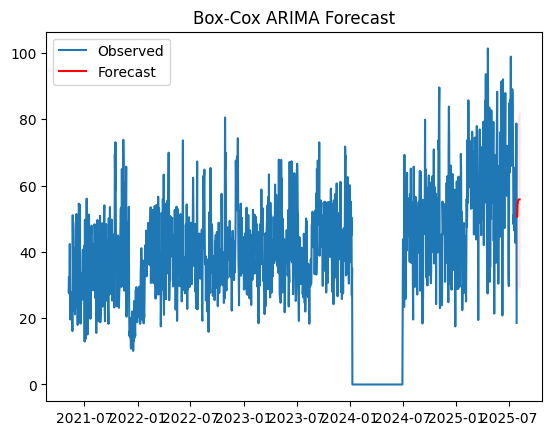

In [48]:
forecast = results.get_forecast(steps=10)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot ARIMA Forecast
plt.plot(df_steps.index, df_steps['steps_boxcox'], label='Observed')
plt.plot(mean_forecast.index, mean_forecast, label='Forecast', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title("Box-Cox ARIMA Forecast")
plt.show()


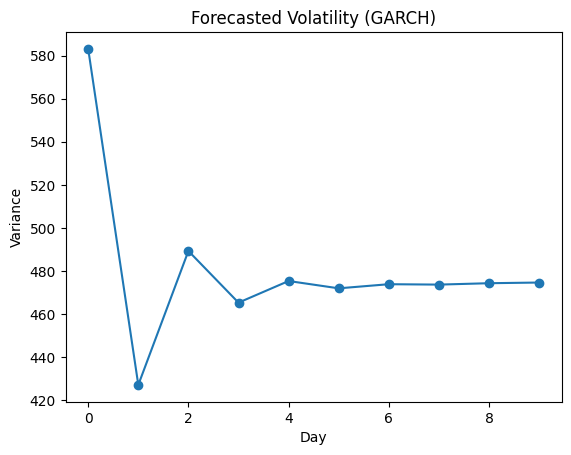

In [49]:
garch_forecast = garch_results.forecast(horizon=10)
volatility_forecast = garch_forecast.variance.values[-1, :]

plt.plot(volatility_forecast, marker='o')
plt.title("Forecasted Volatility (GARCH)")
plt.xlabel("Day")
plt.ylabel("Variance")
plt.show()


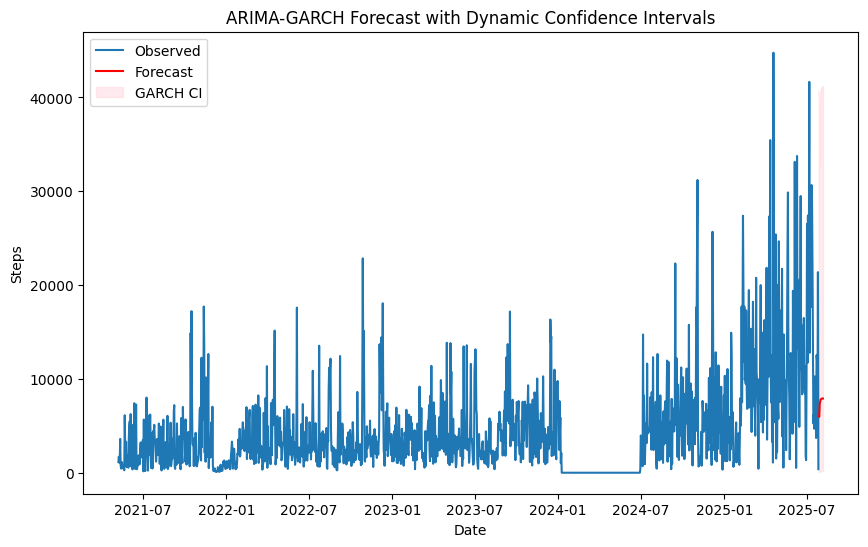

In [52]:
forecast = results.get_forecast(steps=10)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()



garch_forecast = garch_results.forecast(horizon=10)
variance_forecast = garch_forecast.variance.values[-1, :]  # shape (10,)
std_forecast = variance_forecast ** 0.5  # standard deviation




import numpy as np

# Calculate z-score for 95% confidence level
z = 1.96

lower_bound = mean_forecast - z * std_forecast
upper_bound = mean_forecast + z * std_forecast



from scipy.special import inv_boxcox

mean_forecast_original = inv_boxcox(mean_forecast, fitted_lambda)
lower_bound_original = inv_boxcox(lower_bound, fitted_lambda)
upper_bound_original = inv_boxcox(upper_bound, fitted_lambda)


import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df_steps.index, df_steps['steps'], label='Observed')

# Create forecast index (next 10 days)
forecast_index = mean_forecast.index

plt.plot(forecast_index, mean_forecast_original, color='red', label='Forecast')
plt.fill_between(forecast_index, lower_bound_original, upper_bound_original, color='pink', alpha=0.3, label='GARCH CI')

plt.title("ARIMA-GARCH Forecast with Dynamic Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Steps")
plt.legend()
plt.show()
